>## research paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

In [4]:
import torch
import torchvision
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print(f"helper_functions.py already exists, skipping download...")
else:
    print(f"downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as file:
        file.write(request.content)

helper_functions.py already exists, skipping download...


In [6]:
import helper_functions

image_path = helper_functions.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                               destination="pizza_steak_sushi",
                               remove_source=True)
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [8]:
!git clone https://github.com/stanleyedward/pytorch_modules.git

fatal: destination path 'pytorch_modules' already exists and is not an empty directory.


In [9]:
from pytorch_modules.modules import data_preprocess
from torchvision import transforms
#create image size( table 3 of vit paper)
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])
print(f"manually creaated transforms: {manual_transforms}")

manually creaated transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [10]:
#craete a batchsize of 32 (even tho paper uses 4096 we dont have hardware for it)
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_preprocess.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [11]:
### visualize a single image
#get a batch of imge
image_batch, label_batch = next(iter(train_dataloader))
#get a single img and abel form the batch
image, label = image_batch[0], label_batch[0]

#view the abtch shapes
print(f"train_dataloader_batchshape: {image_batch.shape}")

#view the single img shape
image.shape, label

train_dataloader_batchshape: torch.Size([32, 3, 224, 224])


(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

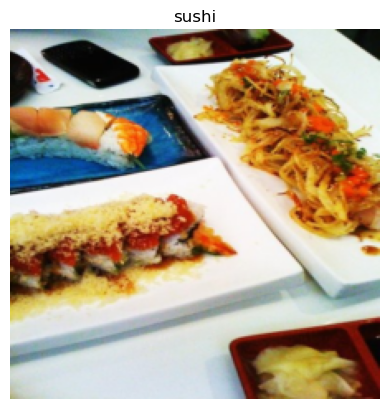

In [12]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)) #as matplotlib takes CHW
plt.title(class_names[label])
plt.axis("off")

# overview of the paper
- figure 1: viual overview of the architecture
- four equations: math equations which define the function ofeach layer/block
- table 1/3: diffrente hyperparamters for the architecture/trianing.
- text

### figure 1
![Alt text](image-2.png)
* embedding - learnable representation (start with random numbers and improve them overtime) 
* mlp = multilevel perceptron



### four equations
![Alt text](image-1.png)

Equaion1:
* embedding - learnable representation (start with random numbers and improve them overtime) 
* path embeddings - patches of original image - pink
* position embeddings - to retain positional information -  purple
* class token embedding - to perform classification (*/pink)

```python
x_input = [learnable_class_token, image_patch_embeddings_1, image_patch_embeddings_2,...image_patch_embeddings_N]+
            [learnable_class_token_pos, image_patch_1_embeddings_pos, image_patch_2_embeddings_pos,...image_patch_N_embeddings_pos]
```

Equation2:
* MSA = Multi-Head self attention (Multi-Head Attension)
* LN = LayerNorm (Norm))
* zv(l-1) = input before LN block, adding residual connections (+)

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input 

```

Equation3:
* MLP = MultiLayer Perceptron
* LN = LayerNorm
* z'v(l) = input before LN block, adding residual connections (+)

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Equation4:
* MLP = MultiLayer Perceptron - a nerual network with x no. of layers
* MLP = one hidden layer at training time
* MLP = single linear layer in fine-tuning time
* LN = LayerNorm

```python
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```
or
```python
y = MLP(LN_layer(x_output_MLP_block)) 
```


### table 1/3:
![Alt text](image-3.png)

#### all different sizes of the same model
#### ViT-B/16 - ViT-Base with image patch size 16x16

* layers = no. of transformers encoder layers
* hidden size $D$  - the embedding size throughout the architecture

                    - if we have embedding size of 768 means 

                    - each image patch that may be 16x16 

                    - is turned into a vector of size 768

                    - learnable vector*
                    
* MLP size - no. of hidden units/neurons in the MLP

            - if the MLP size is 3072 
            - then the no of hidden units in the MLP layer in 3072

* Heads - the number of heads within multihead self-attention layers

        - if heads = 12 we have 12 heads in MSA layer
        
> ![Alt text](image-4.png)
        
        - denoted by h



### text

>## Equation 1: split data into patches and creating the class, position and patch embedding 

### layers = input -> function -> output 

* what's the input shape?
* whats the output shape?

one of the biggest porblems in dl are misaligned tensor shapes

* Input shape: (224,224) -> single image -> (height, width, color channels)
* Output shape: 

* Input shape: $H*W*C$ [hieight,width, color channels]
* output shape: $N\times(P^2*C)$
- H = height
- W = width
- C = Color channels
- P = patchs ize
- N = number of patches = (height*width)/p^2
- D =  constant latent vector size = embedding dimension (see table 1)

In [13]:
# exmaple values 
height = 224
width = 224
color_channels = 3
patch_size = 16

#calc the number of patches
num_patches = int((height *width) / (patch_size**2)) 
num_patches

196

In [14]:
#input shape
embedding_layer_input_shape = (height, width, color_channels)

#otput shape
embedding_layer_output_shape = (num_patches, patch_size**2 * color_channels)

print(f"input shape( single@D iamge): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of pathces): {embedding_layer_output_shape}")

input shape( single@D iamge): (224, 224, 3)
Output shape (single 1D sequence of pathces): (196, 768)


* Input shape: (224,224) -> single image -> (height, width, color channels)
* Output shape: (196,768) -> (number of patches, embedding_dimension)   ; embedding dimension = $D$ from table 1

## turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

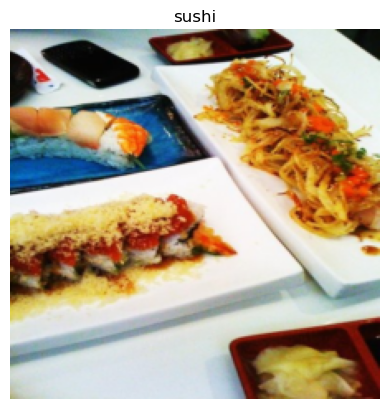

In [15]:
#view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off")

In [16]:
image.shape

torch.Size([3, 224, 224])

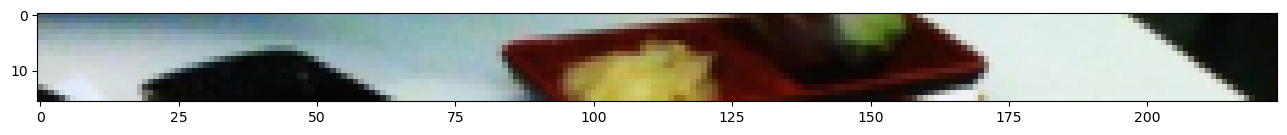

In [17]:
#get the top row of the image
image_permuted = image.permute(1,2,0) #HWC for matplotlib

#index to plot the top row of pixels
patch_size = 16 #from paper
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
 Patch size:16 x 16 pixels
0 0
1 16
2 32
3 48
4 64
5 80
6 96
7 112
8 128
9 144
10 160
11 176
12 192
13 208


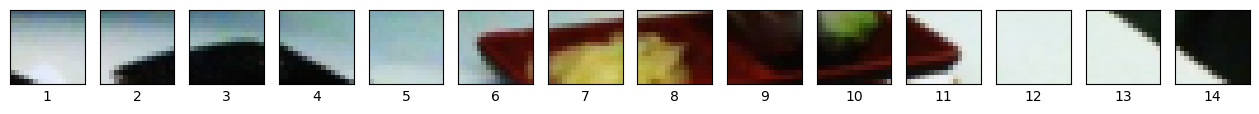

In [18]:
#setup code t oplot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "image size must be divisble by patch size"
print(f"Number of patches per row: {num_patches}\n Patch size:{patch_size} x {patch_size} pixels")
#create a series of subplots
fig, axis = plt.subplots(nrows=1,
                         ncols=img_size// patch_size, #one column for each patch
                         sharex=True,
                         sharey=True,
                         figsize = (patch_size,patch_size)
)

#iterate thorugh the patches in the top row 
for i, patch in enumerate(range(0,img_size, patch_size)): #from 0 to img_size with step of patchsize 
    print(i,patch)
    axis[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axis[i].set_xlabel(i+1)
    axis[i].set_xticks([])
    axis[i].set_yticks([])
    

Number of parches per row: 14.0    
Number of patches per column: 14.0        
Patch size: 16 x 16 pixels


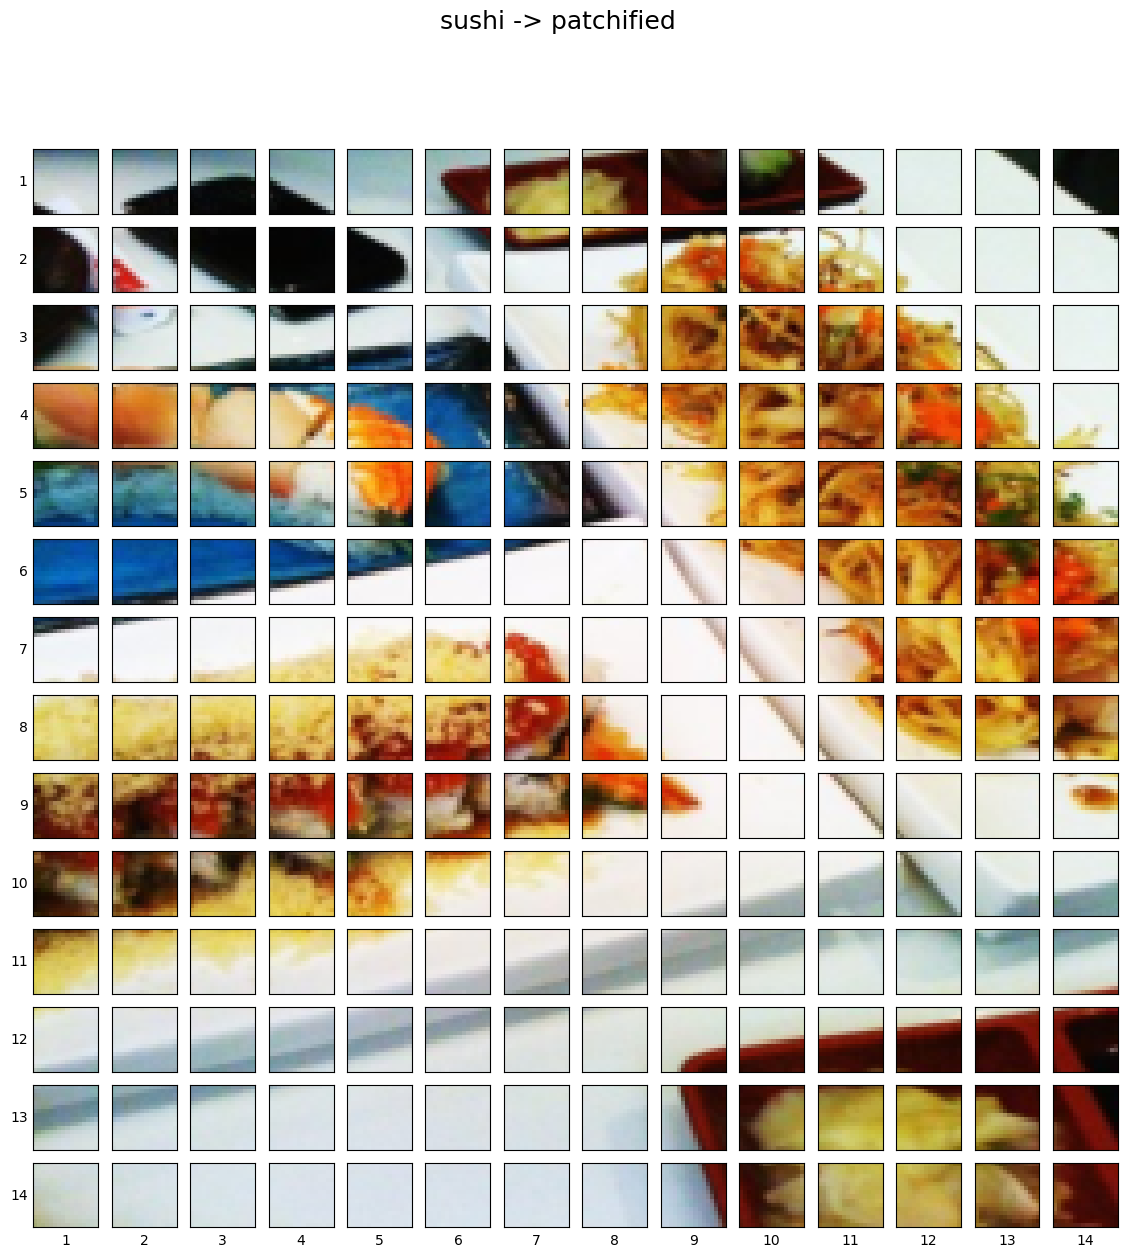

In [19]:
#plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "image size must be divisble by patch size"
print(f"Number of parches per row: {num_patches}\
    \nNumber of patches per column: {num_patches}\
        \nPatch size: {patch_size} x {patch_size} pixels")

# craete a series of subplots 
fig, axis = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         figsize=(num_patches,num_patches),
                         sharex=True,
                         sharey=True)

#loop thuough the height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        #plot the permuted img o n the diffrent axes
            # print(i,j,patch_height, patch_width)
            axis[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, #iterate through height
                                             patch_width:patch_width+patch_size, #iterante though width
                                             :])#get all color channels
            axis[i, j].set_ylabel(i+1,
                                  rotation="horizontal",
                                  horizontalalignment="right",
                                  verticalalignment="center")
            axis[i, j].set_xlabel(j+1)
            axis[i, j].set_xticks([])
            axis[i, j].set_yticks([])
            axis[i ,j].label_outer()
#set up the title fo rth plot
fig.suptitle(f"{class_names[label]} -> patchified", fontsize=18)
plt.show()

In [20]:
14*14 #patches

196

## creating image patches and turning them into patch embeddings

* perhaps we could create the image patches and imge patch embedding ina  single step using 
`torch.nn.Conv2d()` and setting the kernel size and stride to `patch_size`.
- a convolutinal feature map is a laernable representation or `an embedding`

In [21]:
#create conv2d layer to turn image into patches of learnable feature mas (embeddings))
from torch import nn
#set the patchpisze
patch_size = 16
#create a conv2d layers with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, #D size from table 1 for ViT-Base, embedding size
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

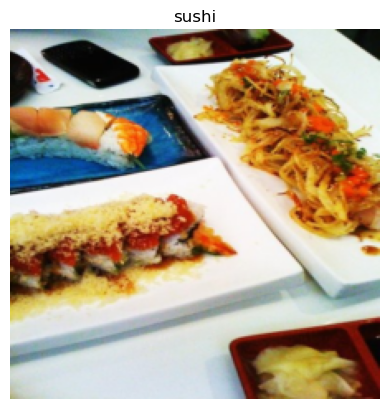

In [22]:
#view single image
plt.title(class_names[label])
plt.imshow(image.permute(1,2,0))
plt.axis(False)

In [23]:
#paass the image thorugh the conv layer
image_out_of_conv = conv2d(image.unsqueeze(0)) #batchdimension  -> [batchsize, color channels, hieght, width]
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [24]:
14*14 #number of patchsizes WE NEED TO FLATTEN

196

Now we've passed a single image into our conv2d layers we got 
```python
torch.Size([1, 768, 14, 14]) # [batchsize, embedding_dim, feature_map_height, feature_map_width]
```

In [25]:
image_out_of_conv

tensor([[[[-0.8176, -0.6418, -0.4872,  ..., -0.9703, -1.1312, -0.1001],
          [ 0.1144, -1.0577, -0.0710,  ..., -0.9847, -0.9749, -1.0478],
          [-0.1704, -0.8053, -0.8679,  ..., -0.5460, -0.9633, -0.9834],
          ...,
          [-0.8920, -0.8767, -0.8284,  ..., -0.2783, -0.0771, -0.0393],
          [-0.5517, -0.7117, -0.8999,  ..., -0.7478, -0.5068, -0.2653],
          [-0.8195, -0.9055, -0.9085,  ..., -0.7738, -0.6856, -0.2766]],

         [[ 0.2103,  0.0262,  0.1776,  ...,  0.1928, -0.0795, -0.0666],
          [ 0.1943, -0.1549, -0.0810,  ...,  0.2548,  0.1995,  0.2183],
          [ 0.0303,  0.2294,  0.2619,  ...,  0.0968,  0.2565,  0.1995],
          ...,
          [ 0.1954,  0.1974,  0.2271,  ...,  0.0490, -0.0248, -0.0835],
          [ 0.1049,  0.1207,  0.2112,  ...,  0.0725, -0.0680, -0.1647],
          [ 0.1959,  0.1957,  0.1952,  ...,  0.0679, -0.0498, -0.0540]],

         [[-0.2767, -0.0257,  0.2721,  ..., -0.2781, -0.4082, -0.3389],
          [ 0.0148, -0.2530, -

In [26]:
image_out_of_conv.requires_grad

True

showing random convolutional feature maps from indexes: [705, 69, 186, 740, 281]


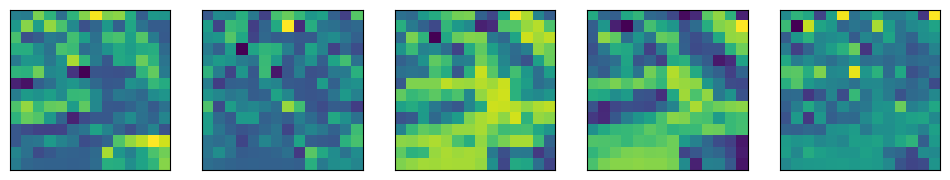

In [27]:
#plot random conv feature maps (embeddings)
import random
random_indexes = random.sample(range(0,768), k=5)
print(f"showing random convolutional feature maps from indexes: {random_indexes}")

# cretea a plot
fig, axis = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(12,12)
)

#plot rnadom image feature maps
for i, index in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, index, :, :]# index on the output tensor of the conv2d layer
    axis[i].imshow(image_conv_feature_map.squeeze().detach().numpy())#remove batch dim #remove from grad tracking/ switch to numpy for matplotlib
    axis[i].set(
        xticklabels=[],
        yticklabels=[],
        xticks=[],
        yticks=[]
    )

In [28]:
#get a single feature map in tensor form 
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad, single_feature_map.shape


(tensor([[[-0.8176, -0.6418, -0.4872, -0.5758, -0.7243, -0.4365, -0.2517,
           -0.1883, -0.1010, -0.2052, -0.3501, -0.9703, -1.1312, -0.1001],
          [ 0.1144, -1.0577, -0.0710,  0.0083,  0.0727, -0.9256, -0.6416,
           -0.8521, -0.8934, -0.7018, -0.9052, -0.9847, -0.9749, -1.0478],
          [-0.1704, -0.8053, -0.8679, -0.8285, -0.9246, -0.6688, -0.9587,
           -1.0630, -0.5454, -0.4330, -0.4856, -0.5460, -0.9633, -0.9834],
          [-0.4468, -0.6124, -0.8217, -0.9025, -0.7151, -0.4206,  0.0774,
           -0.9059, -0.6263, -0.5677, -0.6230, -0.7193, -0.5842, -0.9423],
          [-0.3769, -0.3758, -0.4067, -0.5090, -0.7041, -0.1277, -0.2635,
           -0.5493, -1.1305, -0.7572, -0.6042, -0.3964, -0.3973, -1.0628],
          [-0.1667, -0.2729, -0.4155, -0.3927, -0.3325, -0.8999, -1.0067,
           -1.0335, -0.9814, -0.9558, -0.5720, -0.5380, -0.5040, -0.5470],
          [-1.0526, -1.0946, -1.0253, -1.0834, -0.9792, -0.9339, -0.6786,
           -1.0560, -1.0755, -0.

## flattening the patch embedding/ feature map with torch.nn.flatten
right now we've got a series of conv faeture maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satusfy the criteria of the
ViT 

In [29]:

print(f"{image_out_of_conv.shape} -> [batch_size, embeddingdim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size, embeddingdim, feature_map_height, feature_map_width]


### went [batch_size, num_of_patches, embeddingdim]

In [30]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, 
                           end_dim=3)
flatten_layer(image_out_of_conv).shape #the order is still not w

torch.Size([1, 768, 196])

### order is still not correct

Originval image shape: torch.Size([3, 224, 224])
image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape : torch.Size([1, 768, 196])


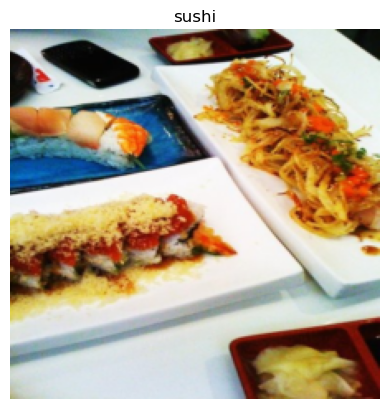

In [31]:
#put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Originval image shape: {image.shape}")

#turn image into faeture maps
image_out_of_conv = conv2d(image.unsqueeze(0))#add batch dim
print(f"image feature map (patches) shape: {image_out_of_conv.shape}")

#flatten the faeture maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape : {image_out_of_conv_flattened.shape}")

In [32]:
#rearrage output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> [batchsize, num of patches, embedding dimension]")

torch.Size([1, 196, 768]) -> [batchsize, num of patches, embedding dimension]


In [33]:
#get a single flattened feature map 
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map, single_flattened_feature_map.shape

(tensor([[-0.8176, -0.6418, -0.4872, -0.5758, -0.7243, -0.4365, -0.2517, -0.1883,
          -0.1010, -0.2052, -0.3501, -0.9703, -1.1312, -0.1001,  0.1144, -1.0577,
          -0.0710,  0.0083,  0.0727, -0.9256, -0.6416, -0.8521, -0.8934, -0.7018,
          -0.9052, -0.9847, -0.9749, -1.0478, -0.1704, -0.8053, -0.8679, -0.8285,
          -0.9246, -0.6688, -0.9587, -1.0630, -0.5454, -0.4330, -0.4856, -0.5460,
          -0.9633, -0.9834, -0.4468, -0.6124, -0.8217, -0.9025, -0.7151, -0.4206,
           0.0774, -0.9059, -0.6263, -0.5677, -0.6230, -0.7193, -0.5842, -0.9423,
          -0.3769, -0.3758, -0.4067, -0.5090, -0.7041, -0.1277, -0.2635, -0.5493,
          -1.1305, -0.7572, -0.6042, -0.3964, -0.3973, -1.0628, -0.1667, -0.2729,
          -0.4155, -0.3927, -0.3325, -0.8999, -1.0067, -1.0335, -0.9814, -0.9558,
          -0.5720, -0.5380, -0.5040, -0.5470, -1.0526, -1.0946, -1.0253, -1.0834,
          -0.9792, -0.9339, -0.6786, -1.0560, -1.0755, -0.9244, -0.9415, -0.6630,
          -0.687

## ^embedding vector that one of our images is represented by, 768 of these flattened vectors
## these are learnable ie they are update upon training

(-0.5, 195.5, 0.5, -0.5)

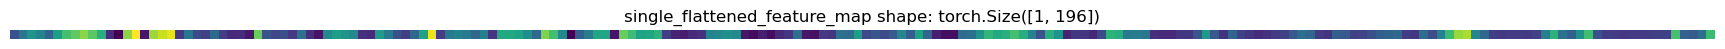

In [34]:
#plot the flattened feature map visually 
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"single_flattened_feature_map shape: {single_flattened_feature_map.shape}")
plt.axis("off")

## Turning the ViT patch embedding layer into a pytorch modeule
we want this module to do a few things.
1. Create a class called PatchEmbedding that inherits from nn.Module
2. Initialize with appropriate hyperparameters, such a schannels, embedding dimension, patch_size.
3. create a layer to turn an imamge into embedded patches using nn.Conv@d().
4. create a layer to flatten the feautre maps of the output of the layer in 3.
5. define forward() that defines the forward computations (eg. pass through layer from 3 to 4)
6. make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [35]:
#1. create a class called Patchembedding
class PatchEmbedding(nn.Module):
    #2. initialize the layer owth appropriate hyperparamters
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768): #from table 1 for ViT_base
        super().__init__()
        self.patch_size = patch_size
        #3. creata a layer to turn an image into embedded patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        #4. create a layer to flatten feature maps outputs of conv2d
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        #creata assertion to mkae sure the image resolution is compatable with the patch size
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patchsize, image shape: {image_resolution}, patch_size = {self.patch_size}"
        
        #perfrm forawrd pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        #6. make sure thereturned sequence embeddign dim are in the righ torder [batchsize,no of patches, embdedding dim]
        return x_flattened.permute(0,2,1)
    

In [36]:

#ccreate an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# pass a single image thorugh the patch embedding layer
print(f"input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batchdim
print(f"output patch embedding sequence shape: {patch_embedded_image.shape}")


input image size: torch.Size([1, 3, 224, 224])
output patch embedding sequence shape: torch.Size([1, 196, 768])


In [37]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad =torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor_bad) 

AssertionError: Input image size must be divisible by patchsize, image shape: 250, patch_size = 16

### we get an error as we made an assertion to make sure our input image is compatible iwth our patch_size

## creating the class token embedding 
* want to prepend a learnable class token to the start of the patch embedding
* in order to perform classificaiton we use the standard approach of adding an extra learnable classification token 

In [38]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

after we prepend the class token it should become [1,197, 768]

In [39]:
#get the batchsize and embedding dimension 
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [40]:
#create class token embedding as a laernable paramter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)  # to make the paramter learnable its on by default
class_token.shape


torch.Size([1, 1, 768])

### USING ONES TO MAKE IT MORE VISIBLE for learning
### NOTe: use randn in practical use

In [41]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [42]:
#add the class token embedding to the from of the patch embedding # From the paper
patch_embedded_image_with_class_embedding= torch.cat((class_token, patch_embedded_image),
                                                     dim=1) #no of patches dim 
print(f"{patch_embedded_image_with_class_embedding.shape} -> batch_size, class_token + no_of_patches, embedding_dim")

torch.Size([1, 197, 768]) -> batch_size, class_token + no_of_patches, embedding_dim


In [43]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.6096, -0.1588, -0.4739,  ...,  0.6895,  0.2181, -0.1245],
         [ 0.5337, -0.0242, -0.7186,  ...,  0.4584,  0.3779, -0.2824],
         ...,
         [ 0.3806, -0.1637, -0.5343,  ...,  0.5527,  0.1557, -0.0821],
         [ 0.3234, -0.0631, -0.2819,  ...,  0.3920,  0.2609, -0.0500],
         [ 0.0698,  0.0578, -0.2199,  ...,  0.1429, -0.0180,  0.0352]]],
       grad_fn=<CatBackward0>)

## creating the position embedding

want to: create a series of 1d learnable positionembedding and to add them to the sequence of patch embeddings

In [44]:
#view the sequence of patch embeddinigs withthe prepended class embeddings
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.6096, -0.1588, -0.4739,  ...,  0.6895,  0.2181, -0.1245],
          [ 0.5337, -0.0242, -0.7186,  ...,  0.4584,  0.3779, -0.2824],
          ...,
          [ 0.3806, -0.1637, -0.5343,  ...,  0.5527,  0.1557, -0.0821],
          [ 0.3234, -0.0631, -0.2819,  ...,  0.3920,  0.2609, -0.0500],
          [ 0.0698,  0.0578, -0.2199,  ...,  0.1429, -0.0180,  0.0352]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [45]:
#calculate the N no of  patches
num_patches = int((height * width) / patch_size**2)
#get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
embedding_dimension

#create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(batch_size, #batchsize or 1
                                             num_patches+1, #from paper # and as we added the class token  we get 197 instead of 196
                                             embedding_dimension),
                                  requires_grad=True) #learnable so it gets updated during training
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

Add the position embedding to the patch and class token embeddding

In [46]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.6096, -0.1588, -0.4739,  ...,  0.6895,  0.2181, -0.1245],
          [ 0.5337, -0.0242, -0.7186,  ...,  0.4584,  0.3779, -0.2824],
          ...,
          [ 0.3806, -0.1637, -0.5343,  ...,  0.5527,  0.1557, -0.0821],
          [ 0.3234, -0.0631, -0.2819,  ...,  0.3920,  0.2609, -0.0500],
          [ 0.0698,  0.0578, -0.2199,  ...,  0.1429, -0.0180,  0.0352]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [47]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape
# print(patch_and_position_embedding)
# print(f"patch and position embedding shape: {patch_and_position_embedding.shape}")

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [1.6096, 0.8412, 0.5261,  ..., 1.6895, 1.2181, 0.8755],
          [1.5337, 0.9758, 0.2814,  ..., 1.4584, 1.3779, 0.7176],
          ...,
          [1.3806, 0.8363, 0.4657,  ..., 1.5527, 1.1557, 0.9179],
          [1.3234, 0.9369, 0.7181,  ..., 1.3920, 1.2609, 0.9500],
          [1.0698, 1.0578, 0.7801,  ..., 1.1429, 0.9820, 1.0352]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

## as you can see all the values increased by one as we created positional embeddding with `torch.ones`
## successfully added it to the patch_embeddings with class_token

## finally finished equation 1 :D

## PUTTIGN IT ALL TOGETHER (EQ:1) in one cell

>## equation 1
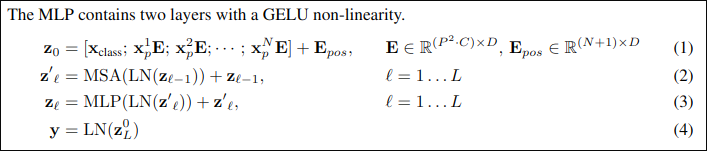

In [58]:
import helper_functions
#set the seeds
helper_functions.set_seeds()

#!set the patch ize: there are multiple patchsizes in the paper we use 16
patch_size = 16

#2. print the sahapes of the original image and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

#3. get the image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

#4.create a patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768) #inline with ViT-base in table 1
#5. pass input iamge through patchembedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")
#6.creating class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension), #using ones for laerning use randn for practical architecture
                          requires_grad=True)
print(f"class token embedding shape: {class_token.shape}")
#7. prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"patch_embedding with class token shape :{patch_embedding_class_token.shape}")
#8.create position embedding 
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) #look at paper for plus 1
#9. add the posotion embedding to patch embedding with class otken
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"patch_and_position_embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
class token embedding shape: torch.Size([1, 1, 768])
patch_embedding with class token shape :torch.Size([1, 197, 768])
patch_and_position_embedding shape: torch.Size([1, 197, 768])


># Equation 2.
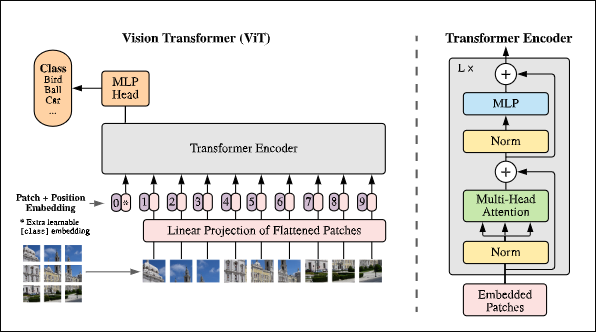

## we finished embedding the patches 
## now we enter the transformer encoder
- consists of 2 main blocks of eq.2 and eq.3

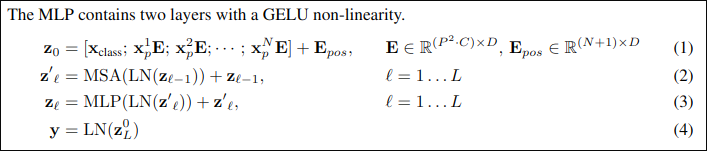
### equation 2 has the MSA block
- for many of these layers like `MSA` pytorch has prebuilt function for the layer

#### from [Attention Is All You Need paper](https://arxiv.org/abs/1706.03762)
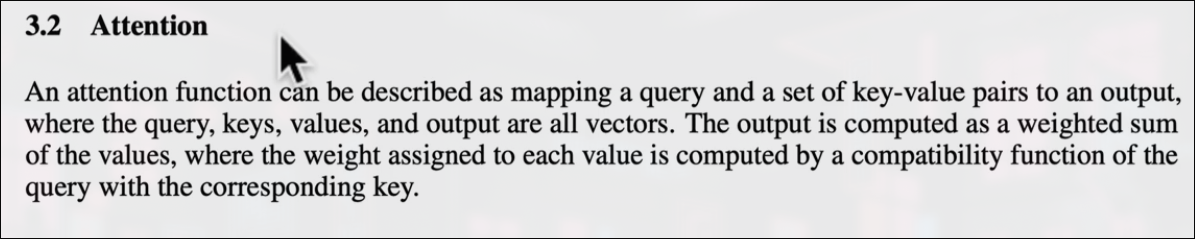

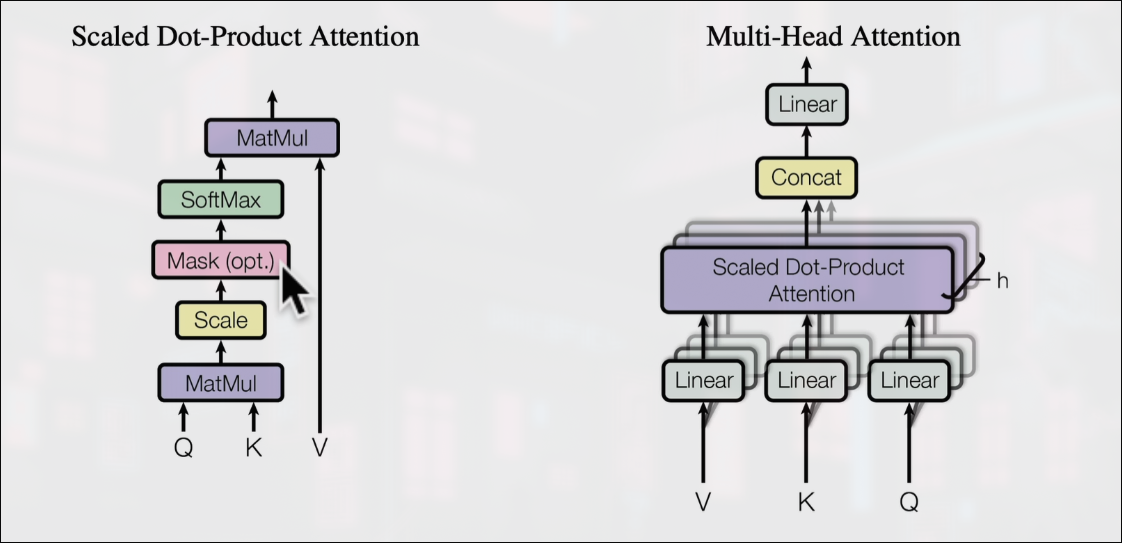

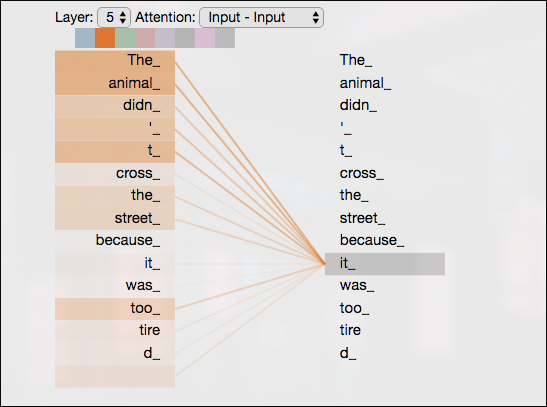

Q- Query, K-key, V-value are instances of the `same` sequence of vectors,

tells us which patch needs to pay how much `attention` to which other word or image patch in the same vector,

to find how much related 1 patch is to another

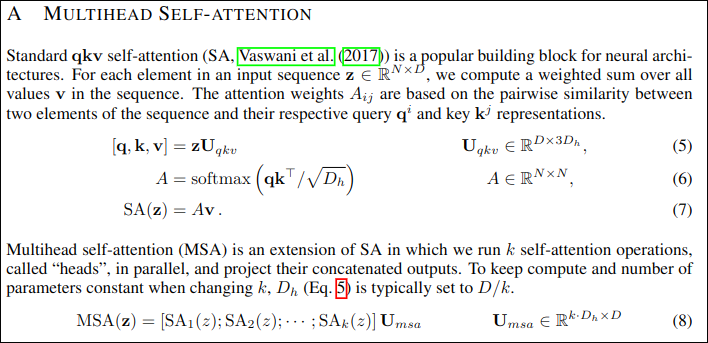

## equation 2 (Multihead self-attention) (msa block)
* MSA: which part of a sequence should pay the most attnetino to itself?
* in our case, we have a series of embedded image atches, which patch significantly relates to another patch.
* we want our nerual network `(ViT)` to learn this relationship/ representation
* to replicate MSA in pytorch use  [pytorch-MSA-doc](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)

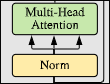 
- as u can see there are 3 arrows from the norm layer entering the MSA block
- these are the instances of the output of the norm layer K,Q,V (Query embeddings, key embeddings, value embeddings) 

## equation 2 (layer normalization) (LN block)
* ### layer norm

            - normalization technique to normalize the distributions of the intermediate layers,
             
            - it enables smoother gradients, faster training, and better generalization accuracy 
- Normalization - make everything have name mean and same std deviation
- mean and std dev are calculated over the last D dimension, where D is the dim of normalized shape

$D$ in our case is the embedding dimensions here [768]

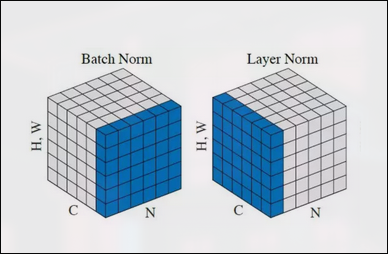
       
        * when we normalize along the embedding dimension, it's like making all of the steps in the staircase to the same size

in docs:
- no of patches = sequence 
- features = embedding dimension

In [70]:
## creating a multihead self attentionlayer in pytorch
class MultiHeadSelfAttentionBlock(nn.Module):
    """creates a multihead self attention block (MSA block)
    """
    def __init__(self,
                 embedding_dimension: int=768, #Hidden size D (embedding dimension) from table 1 for ViT _base
                 num_heads: int=12, #heads from table 1 for ViTbase
                 attn_dropout: int=0):#dropout is only used for dense layer/ fully coneccted/ linaer/ feed forward. but not for QKV projections 
                                        #ie we are not gonna use dropout for our MSA block
        super().__init__()
    #create the norm layer (LN)
        self.layer_norm = nn.LayerNorm( 
            normalized_shape=embedding_dimension#check pytroch docs
        )
        
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dimension, # hidden size D (embedding dimension) from table 1 for ViT-base
            num_heads=num_heads, #no of MSA heads
            dropout=attn_dropout, #zero
            batch_first=True #batch_first – If True, then the input and output tensors are provided as (batch, no of patches or sequence, features or embedding dimension). Default: False (seq, batch, feature) #from pytorch docs
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor: # Q,K and V are x: they are different instances of the same vector
        x = self.layer_norm(x)
        attn_output, _ =  self.multihead_attn(query=x,
                                                key=x,
                                                value=x,
                                                need_weights=False)                  # u can also get attn_weights ie weights of the attention layer #check the docs.
        return attn_output

In [71]:
# create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(
    embedding_dimension=768,
    num_heads=12,
    attn_dropout=0
)

#pass the patch and position image embedding sequence thourgh our MSA Block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA bock: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block; {patched_image_through_msa_block.shape}")

Input shape of MSA bock: torch.Size([1, 197, 768])
Output shape of MSA block; torch.Size([1, 197, 768])


## even tho the shapes haven't changed maybe the values changed??

In [72]:
#input
patch_and_position_embedding 

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1898, 1.1702, 0.7528,  ..., 1.5219, 0.6954, 1.3604],
         [0.2534, 1.1335, 0.9539,  ..., 1.1018, 0.9026, 1.2948],
         ...,
         [0.3991, 1.1046, 0.7861,  ..., 1.4524, 0.6780, 1.2710],
         [0.4800, 1.0405, 0.8942,  ..., 1.3475, 0.7893, 1.1108],
         [0.8555, 1.0100, 0.9064,  ..., 0.9751, 0.8778, 1.1604]]],
       grad_fn=<AddBackward0>)

In [73]:
#output
patched_image_through_msa_block

tensor([[[-0.2758,  0.1351,  0.3654,  ..., -0.1294, -0.2413,  0.0890],
         [-0.2838,  0.1091,  0.3603,  ..., -0.1311, -0.2254,  0.1091],
         [-0.2787,  0.1202,  0.3606,  ..., -0.1269, -0.2202,  0.1050],
         ...,
         [-0.2736,  0.1091,  0.3592,  ..., -0.1333, -0.2194,  0.1178],
         [-0.2737,  0.1115,  0.3609,  ..., -0.1281, -0.2185,  0.1202],
         [-0.2619,  0.1195,  0.3579,  ..., -0.1265, -0.2326,  0.1041]]],
       grad_fn=<TransposeBackward0>)

In [74]:
patched_image_through_msa_block == patch_and_position_embedding

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

## how do we add the skip/residual connection in this?

>## Equation 3: Multilayer perceptron block (MLP block)
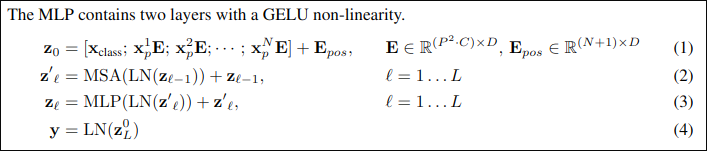

### **MLP** contains two layers with a GELU non-linearlity(mentioned above)

    * MLP = a quite broad term for a block with a series of layer(s), ayers can be multiple or even only one hidden layer.
    * layers can mean: fully connected/ dense/ linear/ feed-forward, all are often similar names for the same thing. 
    In pytorch theyre called `torch.nn.Linear`.
    In tensorflow theyre called `tf.keras.dense
**MLP_size / number of hidden units of MLP** = 3072 for ViT-Base (from table 1)

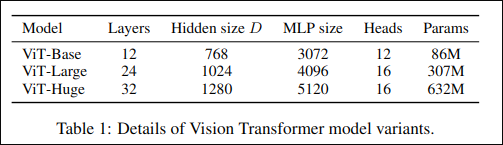

### [what is **GELU** non linearity](https://paperswithcode.com/method/gelu) 
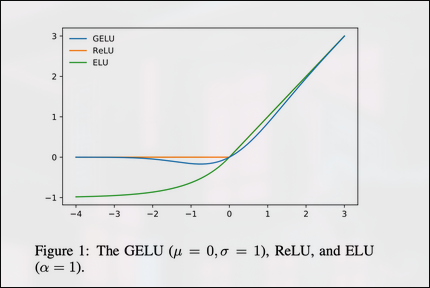

    * the standard Gaussian cumulative distribution function. The GELU nonlinearity weights inputs by their percentile, rather than gates inputs by their sign as in ReLUs (). 
    * Consequently the GELU can be thought of as a smoother ReLU.
    * applies the Gaussin Error Linear Units Functions (GELU)

**Dropout** is applied after every linear layer in MLP

    * value for dropout is available at table 3 Dropout = 0.1 for Vit/b-16

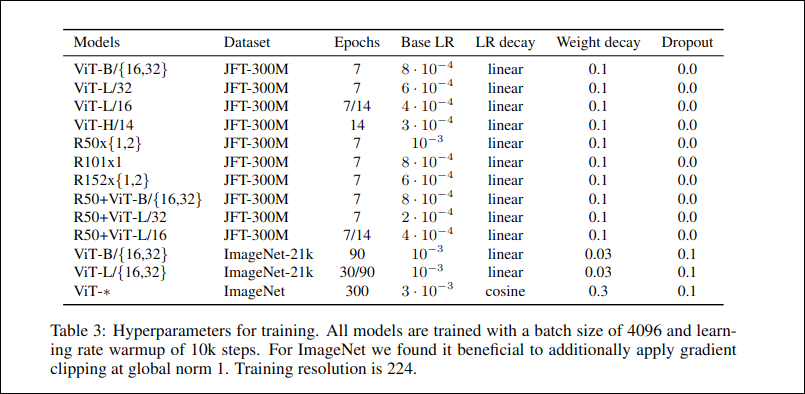

In pseudocode:
```python
#MLP block
x = layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout
```

In [76]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 dropout: int=0.1
                 ):
        super().__init__()
        #creat the norm layer (LN)
        self.layer_norm = nn.LayerNorm(
            normalized_shape=embedding_dim
        )
        
        #creat eh MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size), #project to a larger size # to hopfully capture some fore information 
            nn.GELU(),
            nn.Dropout(
                p=dropout
            ),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim), #squeeze it back to the embedding dimension 
            nn.Dropout(
                p=dropout
            )
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        #return self.mlp(self.layer_norm(x) #same as above# this will benefit from operator fusion 


### side track:  https://horace.io/brrr_intro.html || checkout torch.compile feature that leverages operator fusion mentioned above


In [79]:
#create an instance of MLP block
mlp_block = MLPBlock(embedding_dim=768, #talble 1 value
                     mlp_size=3072, #table 1 value
                     dropout=0.1) #table 3 value

#pass ouot through the MLP block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of the MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of the  MLP blcok: {patched_image_through_mlp_block.shape}")

Input shape of the MLP block: torch.Size([1, 197, 768])
Output shape of the  MLP blcok: torch.Size([1, 197, 768])


In [82]:
#the variables have changed even though the values are the same
patched_image_through_mlp_block == patched_image_through_msa_block

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

## this is not really the correct order of doing things as we havent added the residual connections yet
## we are just creating modules of the final product

># creating the transformer encoder (with residual connections)
The transfformer encoder is a combination of alternating blocks of MSA blocks and MLP blocks
LN is applied between every block, and residual connections after every block

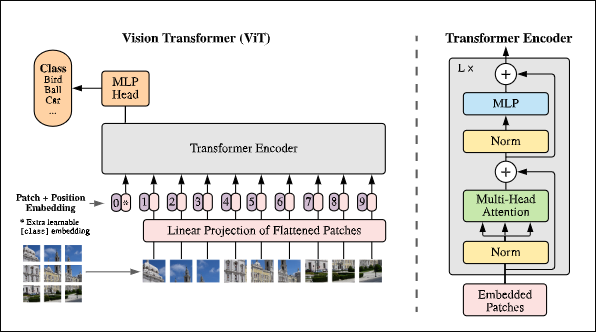

**encoder** = turn a sequence into a laernable representation

**decoder** = turna learnable representation to some sort of sequence

encoders in NLP converts text(sequence) into numbers 
decoders decontructs encoded numbers into text (sequence) (in a translator)

### also known as Seq2Seq
seq2seq is a ml model usually used in NLP. This is also where our transformer came from ie NLP which has `encoders as well as decoders`

thats were our name transformer `encoder` comes from, 
since our goal is image `classification` instead of a decoder we use an `MLP` instead of an `Decoder`

* residual connnections = add alyer(s) input to its subsequent output, 
this enables the creation of deeper networks (prevents weights from getting too small ie preventing `spare networks` or `vanishing gradient problem`)

In pseudo:
```python
#transfomer encoder:
x_input (output/sequence of embedding patches) -> MSA_Block -> [MSA_Block + x_input (residual)] -> MLP_Block -> [MLP_block_output + (MSA_block_output + x_input) ] -> ...
```

### coding in the transformer block

In [ ]:
class TransformerEncoder(nn.Module):
    pass